# ASL Action Recognition

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/05-asl-action-recognition.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/05-asl-action-recognition.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/raw/master/tutorials/05-asl-action-recognition.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table><br><br>

### Connect to EvaDB

In [1]:
%pip install --quiet "evadb[vision,notebook]"
import evadb
cursor = evadb.connect().cursor()
import warnings
warnings.filterwarnings("ignore")

Note: you may need to restart the kernel to use updated packages.


### Download ASL Video

In [2]:
!wget -nc "https://www.dropbox.com/s/ti7ptv0gftbk5ji/computer_asl.mp4?dl=0" -O computer_asl.mp4

#ASL UDF
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/evadb/functions/asl_action_recognition.py -O asl_action_recognition.py 

#Pickle file containing the mapping of the ASL action to index
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/evadb/functions/asl_20_actions_map.pkl -O asl_20_actions_map.pkl

File ‘computer_asl.mp4’ already there; not retrieving.
File ‘asl_action_recognition.py’ already there; not retrieving.
File ‘asl_20_actions_map.pkl’ already there; not retrieving.


### Load video into EvaDB for analysis

In [3]:
cursor.query("DROP TABLE IF EXISTS ASL_ACTIONS;").df()
cursor.query("LOAD VIDEO 'computer_asl.mp4' INTO ASL_ACTIONS").df()

,0
0,Number of loaded VIDEO: 1


### Create a function for analyzing the frames

In [4]:
cursor.query("DROP FUNCTION IF EXISTS ASLActionRecognition;").df()
cursor.query("""
    CREATE FUNCTION IF NOT EXISTS ASLActionRecognition
    INPUT  (Frame_Array NDARRAY UINT8(3, 16, 224, 224))
    OUTPUT (labels NDARRAY STR(ANYDIM))
    TYPE  Classification
    IMPL  'asl_action_recognition.py'
""").df()

09-06-2023 16:06:16 WARNING[drop_object_executor:drop_object_executor.py:_handle_drop_function:0083] Function ASLActionRecognition does not exist, therefore cannot be dropped.


,0
0,Function ASLActionRecognition successfully add...


### Run the function on the video to find the ASL action

In [5]:
response = cursor.query("""
    SELECT FIRST(id), ASLActionRecognition(SEGMENT(data)) 
    FROM ASL_ACTIONS 
    SAMPLE 5 GROUP BY '16 frames';
""").df()

In [6]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    label = detections['aslactionrecognition.labels'][0]
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    while ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        x1, y1, x2, y2 = 350, 100, 900, 500
        # object bbox
        frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
        # object label
        cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness)
        
        # frame label
        cv2.putText(frame, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness) 
    
        video.write(frame)
        # Show every 40th frame
        if frame_id % 40 == 0:
            plt.imshow(frame)
            plt.show()
    
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

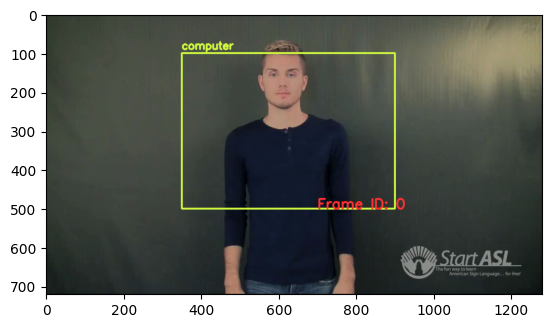

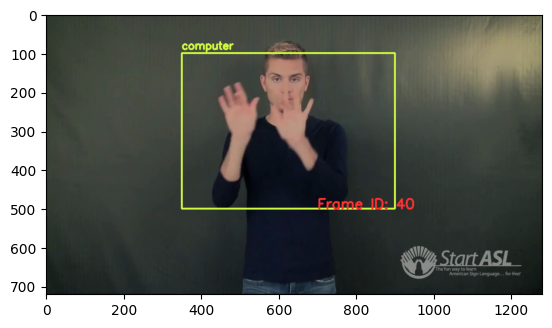

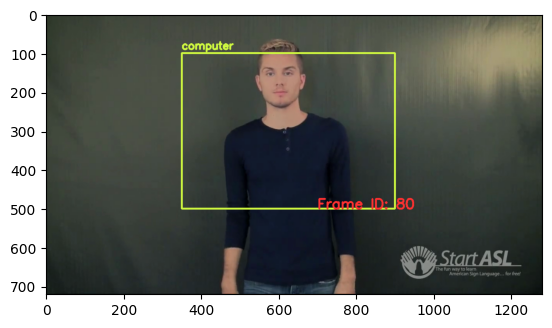

In [7]:
input_path = 'computer_asl.mp4'
output_path = 'computer_annotated.mp4'

annotate_video(response, input_path, output_path)

### Dropping User-Defined Function (UDF)

In [8]:
cursor.query("DROP FUNCTION ASLActionRecognition").df()

,0
0,Function ASLActionRecognition successfully dro...
